In [2]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior, hnn_noise_conn_prob_param_function,
                   load_posterior, simulator_hnn, get_dataset_psd, get_dataset_bandpower,
                   get_parameter_recovery, get_posterior_predictive_check, PriorBetaFiltered)
from viz import plot_spikes_raster
from hnn_core import jones_2009_model, calcium_model
from hnn_core.check import _gid_to_type
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
import scipy


rng_seed = 123
rng = np.random.default_rng(rng_seed)

scale_factor = 60_000

# sns.set()
# sns.set_style("white")

device = 'cpu'

data_path = '/expanse/lustre/scratch/ntolley/temp_project/beta_tuning'

# with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
#     posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)

dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
gid_ranges = sim_metadata['gid_ranges']
gid_to_type = partial(_gid_to_type, gid_ranges=gid_ranges)
# extra_dict = posterior_metadata['extra_dict']
# window_samples = extra_dict['window_samples'] 
theta_extra = sim_metadata['theta_extra']

flow_idx = 3
dpl = np.load(f'{data_path}/sbi_sims/dpl_sbi_{flow_idx}.npy')
theta = np.load(f'{data_path}/sbi_sims/theta_sbi_{flow_idx}.npy')
spike_gids = np.load(f'{data_path}/sbi_sims/spike_gids_sbi_{flow_idx}.npy', allow_pickle=True)
spike_times = np.load(f'{data_path}/sbi_sims/spike_times_sbi_{flow_idx}.npy', allow_pickle=True)

times = np.linspace(0, 1, dpl.shape[1])
mask = times > 0.2 # burn in time
fs = 1000 / dt

net = calcium_model()

(0.16005250000000001, 1.0399975, -5.4471277944776135, 41.95014333527524)

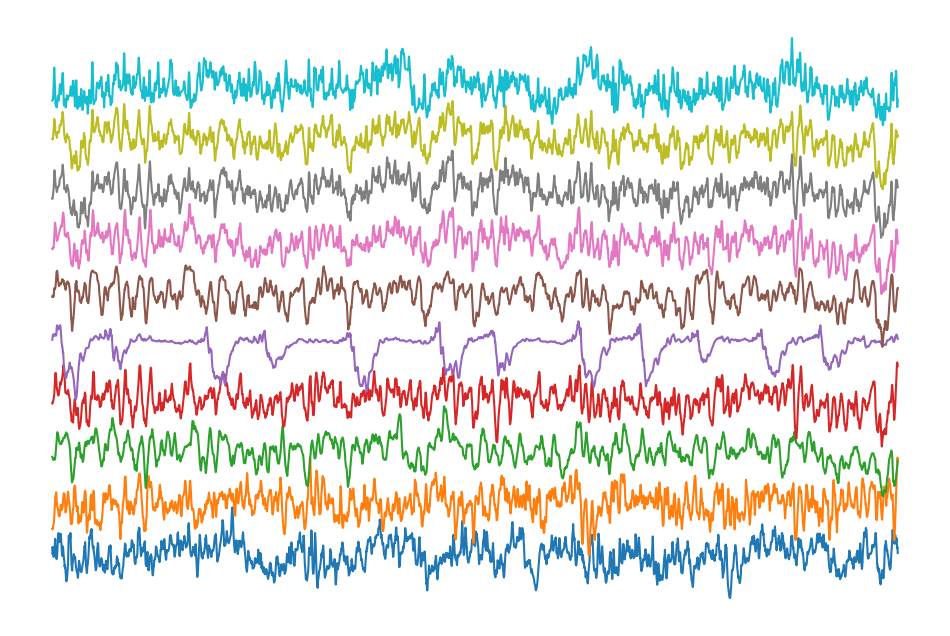

In [3]:
plt.figure(figsize=(12,8))
for sim_idx in range(10):
    sig = dpl[sim_idx, mask] - np.mean(dpl[sim_idx, mask])
    sig = sig / np.std(sig)
    _ = plt.plot(times[mask], sig + (4 * sim_idx))
    
plt.axis('off')

In [4]:
freqs, powers = compute_spectrum(dpl[:, mask], fs, method='welch', avg_type='median')
freqs, powers = trim_spectrum(freqs, powers, [0, 100])

/home/ntolley/anaconda3/envs/sfn_2023/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 20000 is greater than input length  = 16000, using nperseg = 16000
  warnings.warn('nperseg = {0:d} is greater than input length '


In [5]:
N = 73
delay = 0.5 * (N-1) / fs

taps_beta = scipy.signal.firwin(numtaps=73, cutoff=[13, 29], fs=fs, window='hamming', pass_zero=False)
dpl_beta = scipy.signal.lfilter(taps_beta, 1.0, dpl)
beta_hilbert = scipy.signal.hilbert(dpl_beta)
envelope_beta = np.abs(beta_hilbert)

# Coefficient of variation for beta power
beta_cv = np.std(envelope_beta[:,mask], axis=1) / np.mean(envelope_beta[:,mask], axis=1)

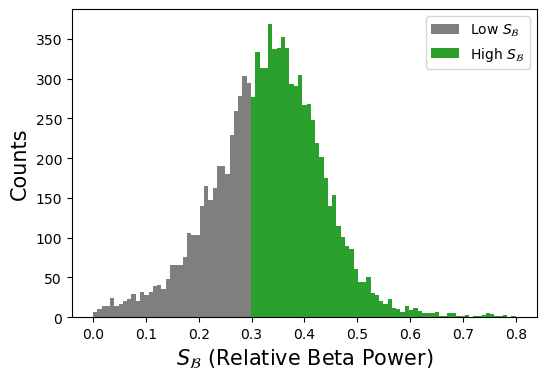

In [6]:
beta_mask = (freqs > 13) & (freqs < 30)
beta_power = powers[:, beta_mask].sum(axis=1)
beta_ratio = beta_power / powers.sum(axis=1)

ratio_sort = np.argsort(beta_ratio)[::-1]
cv_sort = np.argsort(beta_cv)[::-1]

thresh = 0.3
low_beta = beta_ratio < 0.3
high_beta = beta_ratio > 0.3


bins = np.linspace(0, 0.8, 100)

plt.figure(figsize=(6,4))
_ = plt.hist(beta_ratio[low_beta], bins=bins, color='C7', label='Low $S_\mathcal{B}$')
_ = plt.hist(beta_ratio[high_beta], bins=bins, color='C2', label='High $S_\mathcal{B}$')

plt.xlabel('$S_\mathcal{B}$ (Relative Beta Power)', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend()


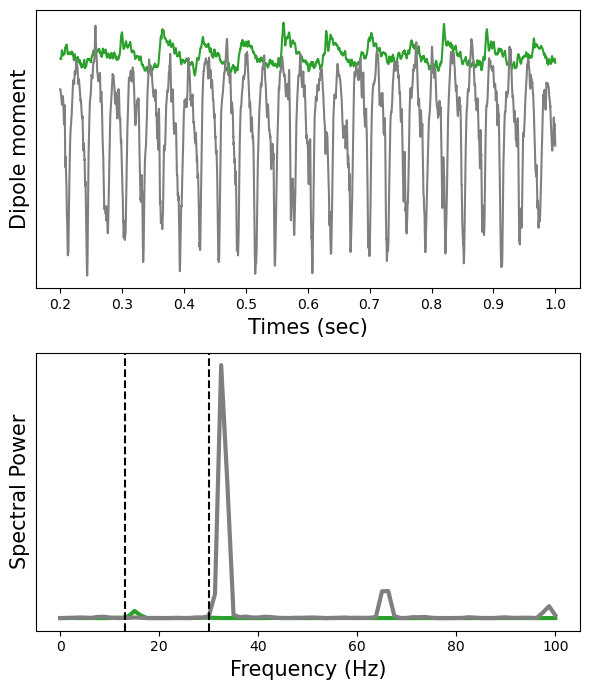

In [7]:
plt.figure(figsize=(6,7))

plt.subplot(2,1,1)
plt.plot(times[mask], dpl[ratio_sort[8],mask] + 0.08, color='C2')
plt.plot(times[mask], dpl[ratio_sort[-2],mask], color='C7')

plt.xlabel('Times (sec)', fontsize=15)
plt.ylabel('Dipole moment', fontsize=15)
plt.yticks([])

plt.subplot(2,1,2)
plt.plot(freqs, powers[ratio_sort[8],:], color='C2', linewidth=3)
plt.plot(freqs, powers[ratio_sort[-2],:], color='C7', linewidth=3)
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.ylabel('Spectral Power', fontsize=15)
plt.yticks([])

plt.axvline(13, color='k', linestyle='--')
plt.axvline(30, color='k', linestyle='--')


plt.tight_layout()

Text(0, 0.5, 'Beta Power CV')

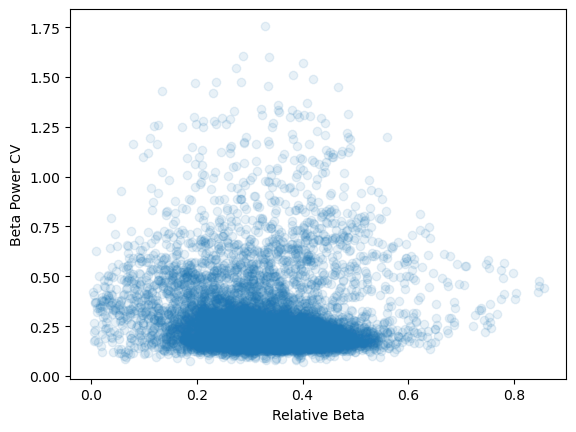

In [8]:
plt.scatter(beta_ratio, beta_cv, alpha=0.1)
plt.xlabel('Relative Beta')
plt.ylabel('Beta Power CV')


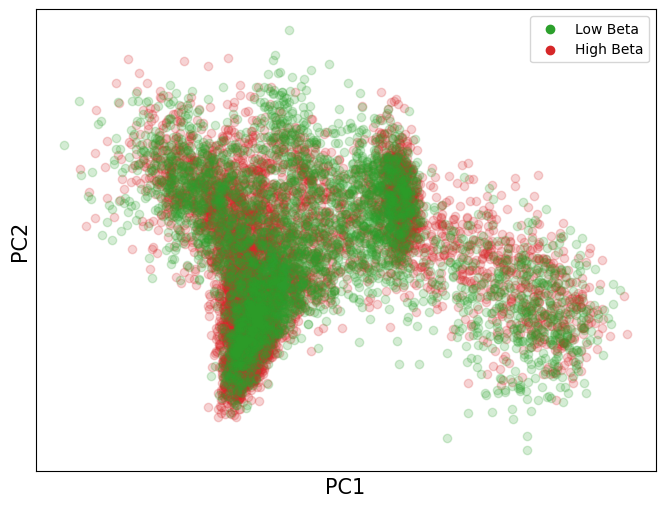

In [9]:
pca = PCA(n_components=len(freqs))
pca_powers = pca.fit_transform(np.log(powers))

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(pca_powers)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
# plt.scatter(pca_powers[:,0], pca_powers[:,1], alpha=0.2)
plt.scatter(pca_powers[high_beta,0], pca_powers[high_beta,1], color='C3', alpha=0.2)
plt.scatter(pca_powers[low_beta,0], pca_powers[low_beta,1], color='C2', alpha=0.2)

plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.xticks([])
plt.yticks([])

plt.scatter([1e10], [1e10], color='C2', label='Low Beta')
plt.scatter([1e10], [1e10], color='C3', label='High Beta')

plt.legend()


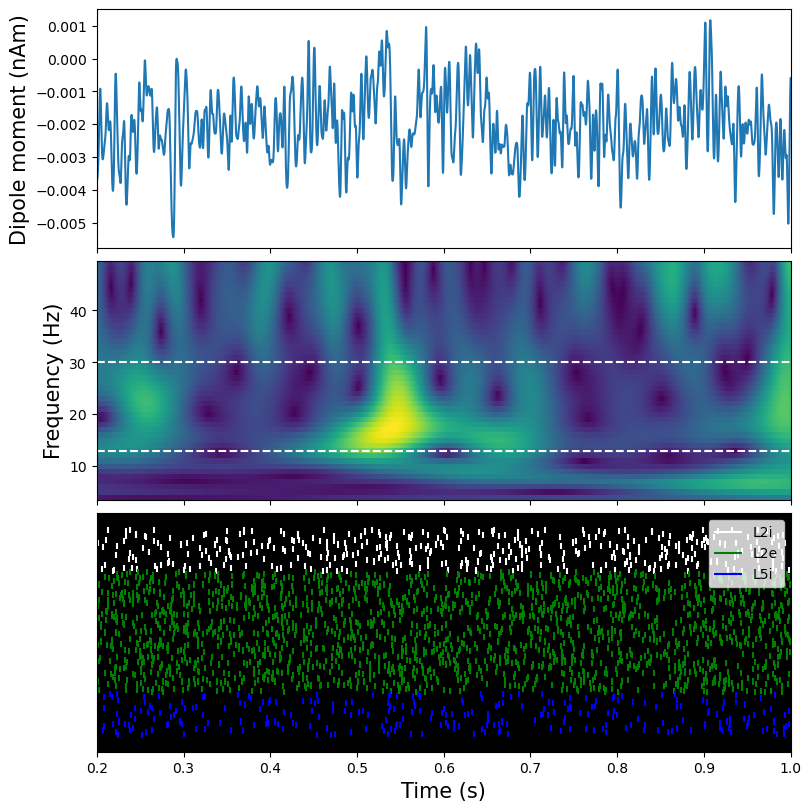

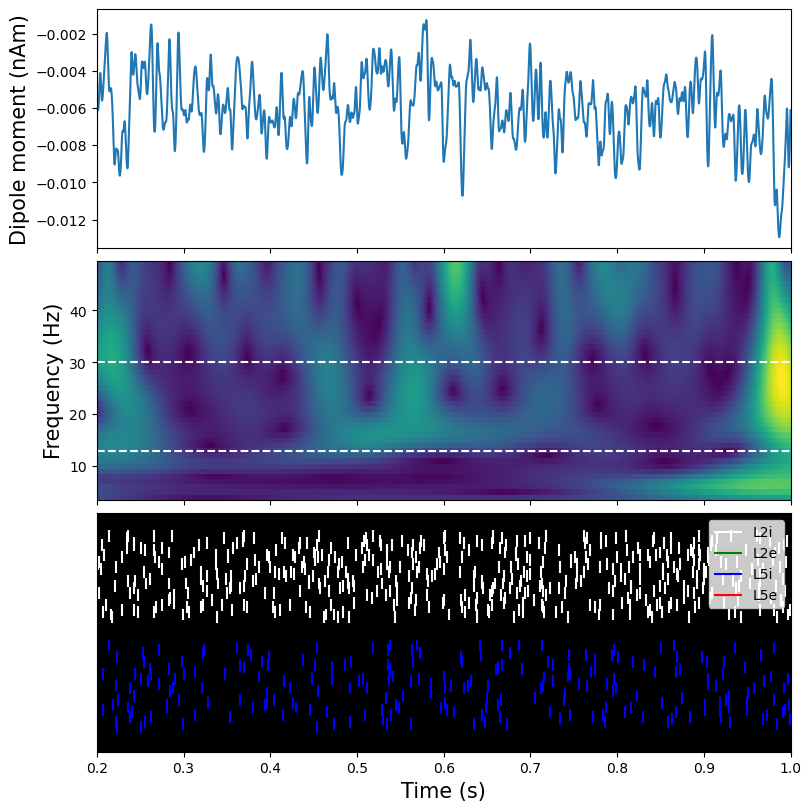

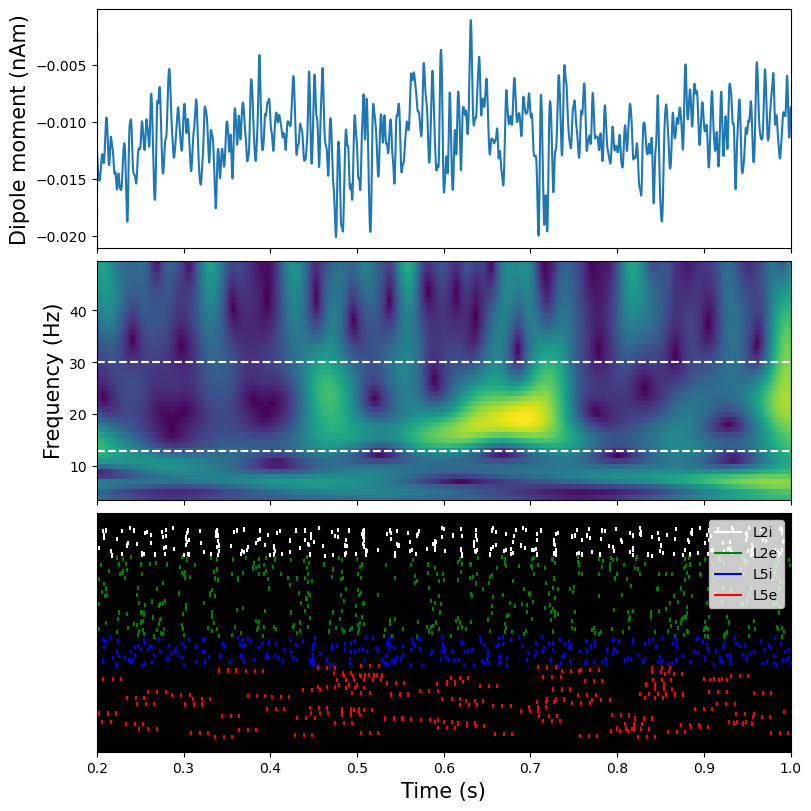

In [12]:
plot_freqs = np.arange(4,50,1)

x_tick_pos = np.linspace(0, times.size, 5)
x_ticks = np.round(np.linspace(times[0], times[-1], 5), 2)

plot_times = times[mask]

for sim_idx in ratio_sort[4050:4053]:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 8),constrained_layout=True)

    sig = dpl[sim_idx,:]
    sig_beta = dpl_beta[sim_idx, :]
    spike_times_trial = np.array(spike_times[sim_idx]) / 1000
    spike_gids_trial = np.array(spike_gids[sim_idx])
    spike_types_trial = np.array(list(map(gid_to_type, spike_gids_trial)))
    
    axes[0].plot(plot_times, sig_beta[mask])
    axes[0].set_ylabel('Dipole moment (nAm)', fontsize=15)
    axes[0].axvline(0.2, color='k', linestyle='--')
    
    mwt = compute_wavelet_transform(sig, fs, plot_freqs, n_cycles=4)
    plot_power = np.abs(mwt[:,mask])
    axes[1].pcolormesh(plot_times, plot_freqs, plot_power)
    axes[1].axhline(13, color='w', linestyle='--')
    axes[1].axhline(30, color='w', linestyle='--')
    axes[1].set_ylabel('Frequency (Hz)', fontsize=15)
    
    plot_spikes_raster(spike_times_trial, spike_gids_trial, spike_types_trial, gid_ranges, ax=axes[2])
    axes[2].set_ylabel('Cell ID', fontsize=15)
    axes[2].set_xlabel('Time (s)', fontsize=15)
    axes[2].set_xlim(0.2, 1)
    
    



In [40]:
n_obs = 200
columns = list(prior_dict.keys())

theta_transformed = linear_scale_array(theta, all_bounds)
df1 = pd.DataFrame(theta_transformed[ratio_sort[:n_obs], :], columns=columns)
df1['beta_type'] = np.repeat('high_beta', n_obs)
df2 = pd.DataFrame(theta_transformed[ratio_sort[-n_obs:], :], columns=columns)
df2['beta_type'] = np.repeat('low_beta', n_obs)

df = pd.concat([df1, df2])
df = df[columns[0:4] + ['beta_type']]

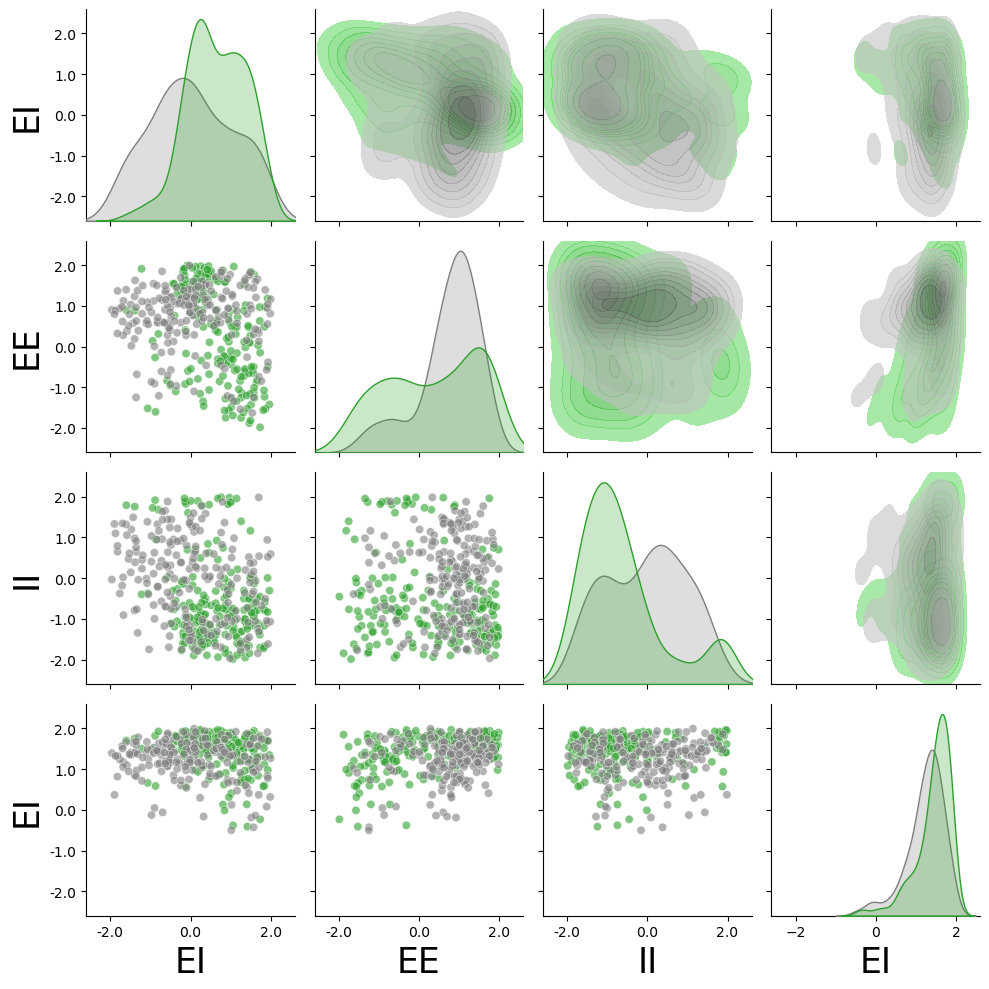

In [54]:
color_dict = {'high_beta': 'C2', 'low_beta': 'C7'}

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
g = sns.PairGrid(df, diag_sharey=False, corner=False, hue='beta_type', palette=color_dict)
# g.map_lower(sns.kdeplot, fill=False, alpha=0.6)
g.map_lower(sns.scatterplot, alpha=0.6)

g.map_upper(sns.kdeplot, fill=True, alpha=0.6)
g.map_diag(sns.kdeplot, fill=True)

param_labels = ['EI', 'EE', 'II', 'EI']
labelsize = 25

for idx in range(4):    
    # Add space to visuzalize groundtruth tick marks at top
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

    g.axes[idx, idx].set_xlim(all_bounds[idx][0] - 0.6, all_bounds[idx][1] + 0.6)
    g.axes[idx, idx].set_ylim(all_bounds[idx][0] - 0.6, all_bounds[idx][1] + 0.6)
    
    # g.axes[idx, idx].set_xlim(-0.2,1.2)
    # g.axes[idx, idx].set_ylim(-0.1,1.2)

    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[3,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

for idx1 in range(4):
    for idx2 in range(3):
        if g.axes[idx1, idx2] != None:
            g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            
plt.tight_layout()